In [1]:
import glob
import os
import json
import pickle as pkl
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [7]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

# Read cutflows from pkl

In [60]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each

#         try:
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
#         except:
#             print(ifile)
#             continue
            
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight


def get_xsecweight(pkl_files, year, ch, sample, is_data):
    
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity[ch][year]) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

def get_cutflow(pkl_files, year, ch, sample, is_data):
    """
    Get cutflow from metadata but multiply by xsec-weight
    """
    xsec_weight = get_xsecweight(pkl_files, year, ch, sample, is_data)
    
    
    
    
    if year == "2018":
        cuts = {
            "mu": ["sumgenweight", "HEMCleaning"],
            "ele": ["sumgenweight", "HEMCleaning"],
        }
    else:
        cuts = {
            "mu": ["sumgenweight"],
            "ele": ["sumgenweight"],
        }
        
    cuts["mu"] += [
            "Trigger",
            "METFilters",
            "OneLep",
            "NoTaus",
            "LepIso",
            "LepMiniIso",
            "OneCandidateJet",
            "CandidateJetpT",
            "LepInJet",
            "JetLepOverlap",
            "dPhiJetMETCut",
    ]
    cuts["ele"] += [
            "Trigger",
            "METFilters",
            "OneLep",
            "NoTaus",
            "LepIso",
            "OneCandidateJet",
            "CandidateJetpT",
            "LepInJet",
            "JetLepOverlap",
            "dPhiJetMETCut",
    ]
        
        
    evyield = dict.fromkeys(cuts[ch], 0)
    for ik, pkl_file in enumerate(pkl_files):
#         try:
        with open(pkl_file, "rb") as f:
            metadata = pkl.load(f)
#         except:
#             continue
            
        cutflows = metadata[sample][year]["cutflows"][ch]

        for key in evyield.keys():

            if key == "sumgenweight":
                evyield[key] += metadata[sample][year][key] * xsec_weight

            else:
                evyield[key] += cutflows[key] * xsec_weight
    return evyield

In [61]:
channels = ["ele", "mu"]

samples_dir = {
    "2016":    "../eos/Dec7_2016",
    "2016APV":    "../eos/Dec7_2016APV",    
    "2017":    "../eos/Dec7_2017",    
    "2018":    "../eos/Dec7_2018",    
}

In [62]:
years = ["2018", "2017", "2016", "2016APV"]
years = ["2018"]

samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

cutflows = {}
for year in years:
    print(f"Processing year {year}")
    
    cutflows[year] = {}
    
    for ch in channels:
        cutflows[year][ch] = {}

        condor_dir = os.listdir(samples_dir[year])

        for sample in condor_dir:

            # get a combined label to combine samples of the same process
            for key in utils.combine_samples:
                if key in sample:
                    sample_to_use = utils.combine_samples[key]
                    break
                else:
                    sample_to_use = sample

            if sample_to_use not in samples:
                continue

            is_data = False
            if sample_to_use == "Data":
                is_data = True

#             print(f"Finding {sample} samples and should combine them under {sample_to_use}")

            out_files = f"{samples_dir[year]}/{sample}/outfiles/"
            pkl_files = glob.glob(f"{out_files}/*.pkl")

            if sample_to_use not in cutflows[year][ch].keys():
                cutflows[year][ch][sample_to_use] = get_cutflow(pkl_files, year, ch, sample, is_data)
            else:
                temp = get_cutflow(pkl_files, year, ch, sample, is_data)
                for key in cutflows[year][ch][sample_to_use]:
                    cutflows[year][ch][sample_to_use][key] += temp[key]
                    
        print(f"------------------------------------------")                    

Processing year 2018
------------------------------------------
------------------------------------------


In [63]:
cutflows["2018"]["mu"]["DYJets"]

{'sumgenweight': 928778102.961436,
 'HEMCleaning': 842390239.9772264,
 'Trigger': 15650037.717472265,
 'METFilters': 15643565.840687772,
 'OneLep': 8623497.252108831,
 'NoTaus': 7367612.349143975,
 'LepIso': 7311988.948920526,
 'LepMiniIso': 7288653.22525193,
 'OneCandidateJet': 305340.60629390244,
 'CandidateJetpT': 116855.31775893093,
 'LepInJet': 68650.87293821659,
 'JetLepOverlap': 20420.557996393,
 'dPhiJetMETCut': 11534.684483343655}

# Combine different channels

In [64]:
common_cuts = [
    "sumgenweight",
    "HEMCleaning",
    "Trigger",
    "METFilters",
    "OneLep",
    "NoTaus",
    "LepIso",
    "LepMiniIso",
    "OneCandidateJet",
    "CandidateJetpT",
    "LepInJet",
    "JetLepOverlap",
    "dPhiJetMETCut",    
]

def combine_channels(cutflows):
    """Must add lepminiso cutflow to electron channel."""
    
    for year in cutflows.keys():
        cutflows[year]["ele_new"] = {}   

        for sample in cutflows[year]["ele"].keys():
            cutflows[year]["ele_new"][sample] = {}

            for cut in common_cuts:
                if (year != "2018") and (cut == "HEMCleaning"):
                    continue

                if cut != "LepMiniIso":
                    cutflows[year]["ele_new"][sample][cut] = cutflows[year]["ele"][sample][cut]
                else:
                    cutflows[year]["ele_new"][sample][cut] = cutflows[year]["ele"][sample]["LepIso"]

    # combine both channels
    cutflows_new = {}
    for year in cutflows.keys():
        cutflows_new[year] = {}
        cutflows_new[year]["lep"] = {}
        
        for ch in ["mu", "ele_new"]:
            for sample in cutflows[year][ch]:
                                
                if sample not in cutflows_new[year]["lep"]:
                    cutflows_new[year]["lep"][sample] = {}
                
                for cut in cutflows[year][ch][sample]:
                    
                    if (year != "2018") and (cut == "HEMCleaning"):
                        continue
                    
                    if cut not in cutflows_new[year]["lep"][sample]:
                        cutflows_new[year]["lep"][sample][cut] = cutflows[year][ch][sample][cut]
                    else:
                        cutflows_new[year]["lep"][sample][cut] += cutflows[year][ch][sample][cut]
        cutflows[year] = {**cutflows[year], **cutflows_new[year]}
    return cutflows

In [65]:
cutflows = combine_channels(cutflows)

In [66]:
cutflows["2018"].keys()

dict_keys(['ele', 'mu', 'ele_new', 'lep'])

In [67]:
cutflows["2018"]["ele_new"]["WJetsLNu"]

{'sumgenweight': 174534156.24243575,
 'HEMCleaning': 152544253.42998582,
 'Trigger': 19610911.867145076,
 'METFilters': 19604260.45292857,
 'OneLep': 14705765.040219942,
 'NoTaus': 14705765.040219942,
 'LepIso': 14666020.040222298,
 'LepMiniIso': 14666020.040222298,
 'OneCandidateJet': 1004898.2436864963,
 'CandidateJetpT': 429668.16663510434,
 'LepInJet': 167356.05221906185,
 'JetLepOverlap': 55525.78137068763,
 'dPhiJetMETCut': 38091.92035000902}

In [800]:
cutflows["2018"]["mu"]["WJetsLNu"]

{'HEMCleaning': 152456857.55824593,
 'Trigger': 27497622.76075047,
 'METFilters': 27487027.431077946,
 'OneLep': 23220936.566750303,
 'NoTaus': 19831202.04224224,
 'LepIso': 19650556.46503639,
 'LepMiniIso': 19595620.436108947,
 'OneCandidateJet': 1198018.1657662333,
 'CandidateJetpT': 511328.95239884075,
 'LepInJet': 186068.4529091031,
 'JetLepOverlap': 71049.09347281557,
 'dPhiJetMETCut': 49270.34303106995}

In [798]:
cutflows["2018"]["lep"]["WJetsLNu"]

{'HEMCleaning': 305001110.9882318,
 'Trigger': 47108534.62789555,
 'METFilters': 47091287.884006515,
 'OneLep': 37926701.60697024,
 'NoTaus': 34536967.082462184,
 'LepIso': 34316576.50525869,
 'LepMiniIso': 34261640.47633125,
 'OneCandidateJet': 2202916.40945273,
 'CandidateJetpT': 940997.119033945,
 'LepInJet': 353424.50512816495,
 'JetLepOverlap': 126574.8748435032,
 'dPhiJetMETCut': 87362.26338107897}

# Combine different years

In [801]:
def combine_years(cutflows):
    """Will remove the HEM cleaning cutflow from 2018 first."""
    
    whatever_year = list(cutflows.keys())[0]
    channels = cutflows[whatever_year].keys()
    
    # combine all years
    cutflows_new = {}
    cutflows_new["Run2"] = {}
    
    for ch in channels:
        cutflows_new["Run2"][ch] = {}
        
        for year in cutflows:
            for sample in cutflows[year][ch]:
                
                if sample not in cutflows_new["Run2"][ch]:
                    cutflows_new["Run2"][ch][sample] = {}

                for cut in cutflows[year][ch][sample]:
                    if "HEM" in cut:
                        continue
                    if cut not in cutflows_new["Run2"][ch][sample]:
                        cutflows_new["Run2"][ch][sample][cut] = cutflows[year][ch][sample][cut]
                    else:
                        cutflows_new["Run2"][ch][sample][cut] += cutflows[year][ch][sample][cut]

    cutflows = {**cutflows, **cutflows_new}

    return cutflows

In [802]:
cutflows = combine_years(cutflows)

In [803]:
cutflows.keys()

dict_keys(['2018', '2017', '2016', '2016APV', 'Run2'])

In [804]:
cutflows["Run2"].keys()

dict_keys(['ele', 'mu', 'ele_new', 'lep'])

# Combine non-dominant backgrounds

In [68]:
# combine non-dominant backgrounds under others
dominant_bkgs = ["WJetsLNu", "QCD", "DYJets", "TTbar"]
signals = ["ggF", "VH", "VBF", "ttH"]

for year in cutflows:
    for ch in cutflows[year]:
        cutflows[year][ch]["Others"] = dict.fromkeys(cutflows[year][ch]["WJetsLNu"], 0)
        for sample in cutflows[year][ch]:
            if sample == "Data":
                continue
            if sample not in signals+dominant_bkgs:
                for cut in cutflows[year][ch][sample]:
                    cutflows[year][ch]["Others"][cut] += cutflows[year][ch][sample][cut]

In [69]:
cutflows["2018"]["ele"].keys()

dict_keys(['DYJets', 'WJetsLNu', 'VBF', 'VH', 'TTbar', 'SingleTop', 'ggF', 'WZQQ', 'QCD', 'Data', 'Diboson', 'ttH', 'Others'])

In [74]:
cutflows["2018"]["lep"]["QCD"]

{'sumgenweight': 13284181901.759933,
 'HEMCleaning': 11607920684.327732,
 'Trigger': 61086555.23502068,
 'METFilters': 60973073.66302854,
 'OneLep': 7862585.62357918,
 'NoTaus': 7225765.694807127,
 'LepIso': 6029014.552542027,
 'LepMiniIso': 1282409.9383668636,
 'OneCandidateJet': 993188.5877481492,
 'CandidateJetpT': 470078.56365667214,
 'LepInJet': 349939.05248699925,
 'JetLepOverlap': 149117.04666754606,
 'dPhiJetMETCut': 77484.95629044574}

# Plot cutflows

In [38]:
plt.rcParams.update({"font.size": 20})

In [75]:
# PLOTTING UTILS
color_by_sample = {
    "ggF": "pink",
    "VH": "tab:brown",
    "VBF": "tab:gray",
    "ttH": "tab:olive",
    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    #     "WplusHToTauTau": "tab:cyan",
    #     "WminusHToTauTau": "tab:cyan",
    #     "ttHToTauTau": "tab:cyan",
    #     "GluGluHToTauTau": "tab:cyan",
    #     "ZHToTauTau": "tab:cyan",
    #     "VBFHToTauTau": "tab:cyan",
    "Others": "tab:grey",
}

cut_to_label = {
    "sumgenweight": "sumgenweight",        
    "HEMCleaning": "HEMCleaning",    
    "Trigger": "Trigger",
    "METFilters": "METFilters",
    "OneLep": "n Leptons = 1",
    "NoTaus": "n Taus = 0",
    "LepIso": r"$\ell$ relative isolation",
    "LepMiniIso": r"$\ell$ mini-isolation",    
    "OneCandidateJet": "n FatJets = 1",
    "CandidateJetpT": r"j $p_T > 250$GeV",
    "LepInJet": r"$\Delta R(j, \ell) < 0.8$",
    "JetLepOverlap": r"$\Delta R(j, \ell) > 0.03$",
    "dPhiJetMETCut": r"$\Delta \phi(\mathrm{MET}, j)<1.57$",
#     "$\mathrm{MET}>20~\GeV$"
} 

combine_samples = {
    # data
    "SingleElectron_": "Data",
    "SingleMuon_": "Data",
    "EGamma_": "Data",
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "ggF",
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    "ttHToNonbb_M125": "ttH",
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
    "GluGluHToTauTau": "HTauTau",
}
signals = ["ggF", "ttH", "VH", "VBF"]

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Work in Progress'))

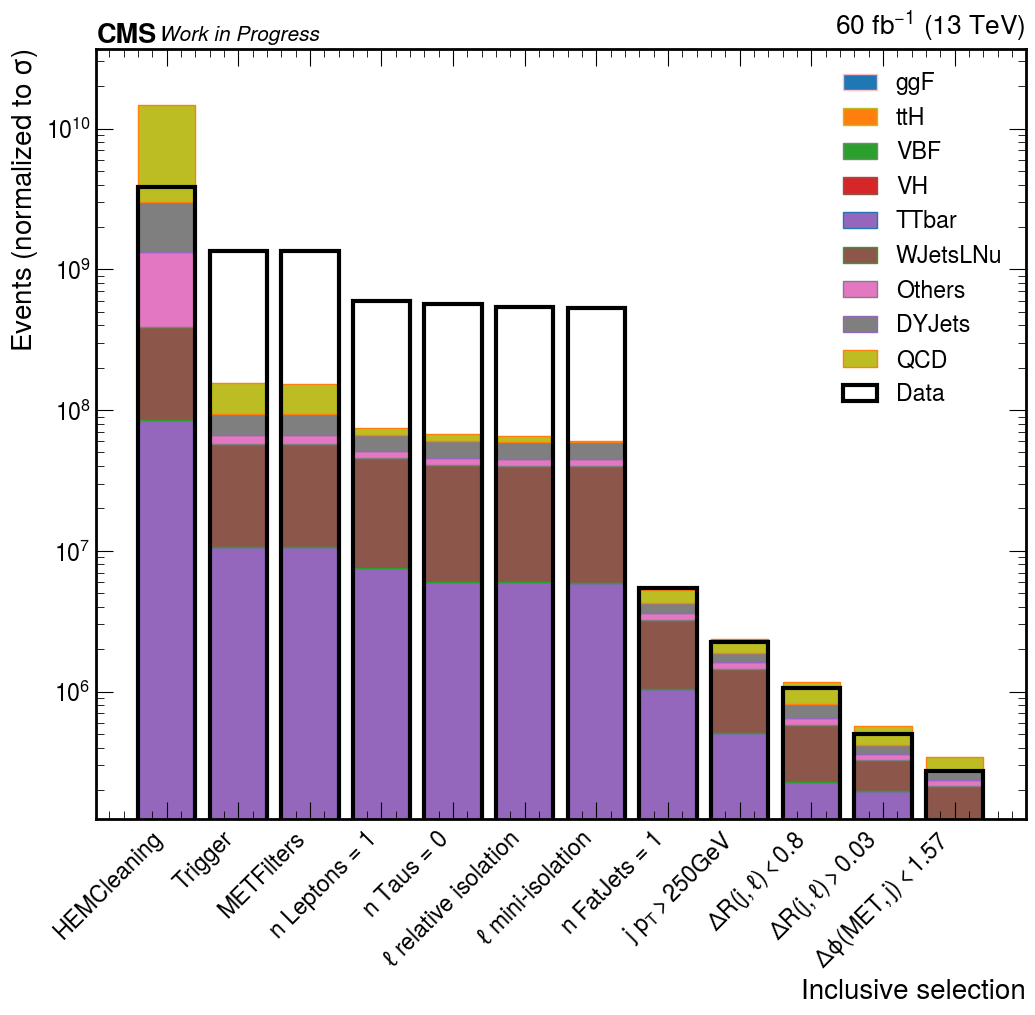

In [40]:
year = "2018"
ch = "lep"

samples = [
    "Data",
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "TTbar",
    "Others"    
#     "WZQQ",    
#     "SingleTop",
#     "Diboson",
]

labels = list(cutflows[year][ch][samples[0]].keys())  
values = [[cutflows[year][ch][sample][label] for label in labels] for sample in samples]
for i, lab in enumerate(labels):
    labels[i] = cut_to_label[lab]

# Sort the samples by yield
sorted_idx = sorted(range(len(values)), key=lambda i: sum(values[i]), reverse=False)
samples = [samples[i] for i in sorted_idx]
values = [values[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(12, 10))
# Plot the cutflows as a stacked bar chart for each sample
bottom = [0] * len(labels)
for i, sample in enumerate(samples):
    
    if sample=="Data":
#         ax.bar(labels, values[i], bottom=0, label=sample, linewidth=3, fill=False)
        continue
    else:
        ax.bar(labels, values[i], bottom=bottom, label=sample, edgecolor=color_by_sample[sample], linewidth=1, fill=True)
        bottom = [sum(x) for x in zip(bottom, values[i])]
    
    
for i, sample in enumerate(samples):
    
    if sample=="Data":
        ax.bar(labels, values[i], bottom=0, label=sample, linewidth=3, fill=False)
    else:
        continue
    
# ax.legend(title="Semi-leptonic channel")
ax.legend()

plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Inclusive selection')
ax.set_ylabel(r'Events (normalized to $\sigma$)')
ax.set_yscale("log")
# ax.set_ylim(1,10**11)
 
hep.cms.lumitext("%.0f " % get_lumi([year], [ch]) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# Latex cutflow table

In [76]:
cuts = {
    "mu": [
        "sumgenweight",
        "HEMCleaning",        
        "Trigger",
        "METFilters",
        "OneLep",
        "NoTaus",
        "LepIso",
        "LepMiniIso",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
    ],
    "ele": [
        "sumgenweight",
        "HEMCleaning",        
        "Trigger",
        "METFilters",
        "OneLep",
        "NoTaus",
        "LepIso",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
    ],  
    "lep": [
        "sumgenweight",
        "HEMCleaning",
        "Trigger",
        "METFilters",
        "OneLep",
        "NoTaus",
        "LepIso",
        "LepMiniIso",
        "OneCandidateJet",
        "CandidateJetpT",
        "LepInJet",
        "JetLepOverlap",
        "dPhiJetMETCut",
    ],
}

In [80]:
parquet_to_latex = {
    "WJetsLNu": "$\PW(\Pell\PGn)$+",
    "QCD": "QCD",
    "DYJets": "$\PZ(\Pell\Pell)$+jets",
    "TTbar": "\\ttbar",
    "Others": "Others",

    "ggF": "ggF",
    "VBF": "VBF",
    "VH": "VH",
    "ttH": "$t\\bar{t}H$",    
    
    "Data": "Data",
}

def make_latex_cutflow_table(cutflows, year, ch, add_data=False, add_sumgenweight=False):
    """"""
        
    
    ### backgrounds
    samples = ["WJetsLNu","QCD","DYJets","TTbar","Others"]
    headers = [parquet_to_latex[s] for s in samples]
    
    textabular = f"l{'r'*len(headers)}"

    data = dict()
    
    for cut in cuts[ch]: 
        if (year != "2018") and (cut == "HEMCleaning"):
            continue
            
        if not add_sumgenweight and cut == "sumgenweight":
            continue
    
        data[cut] = []

        for sample in samples:
            data[cut].append(round(cutflows[year][ch][sample][cut]))
        
    texheader = "\\textbf{Inclusive Selection}" + " & " + " & ".join(headers) + "\\\\"
    texdata = "\\hline\n"
    for label in data:
        if label == "z":
            texdata += "\\hline\n"
        texdata += f"{cut_to_label[label]} & {' & '.join(map(str,data[label]))} \\\\\n"
    texdata += "\\hline\n"    

    ### signal
    if add_data:
        samples2 = [r"ggF","VBF","VH","ttH", "Data"]
    else:
        samples2 = [r"ggF","VBF","VH","ttH"]
    headers2 = [parquet_to_latex[s] for s in samples2]    
    texheader2 = " & " + " & ".join(headers2) + "\\\\"
    texdata2 = "\\hline\n"

    data = dict()
    for cut in cuts[ch]:
        if (year != "2018") and (cut == "HEMCleaning"):
            continue
            
        data[cut] = []

        for sample in samples2:
            data[cut].append(round(cutflows[year][ch][sample][cut]))
        
    for label in data:
        if label == "z":
            texdata += "\\hline\n"
        texdata2 += f"{cut_to_label[label]} & {' & '.join(map(str,data[label]))} \\\\\n"    

    # make table
    print("\\begin{table}[!htp]")
    print("\\begin{center}")
    
    print("\\begin{tabular}{"+textabular+"}")
    print(texheader)
    print(texdata,end="")
    print(texheader2)
    print(texdata2,end="")
    print("\\end{tabular}")
    
    
    if ch == "lep":
        print("\\caption{Event yield of " + year + " Monte Carlo samples normalized to " + str(round(get_lumi([year], [ch]))) + "\\fbinv.}")        
    else:
        print("\\caption{Event yield of " + ch + " channel " + year + " Monte Carlo samples normalized to " + str(round(get_lumi([year], [ch]))) + "\\fbinv.}")
        
    print("\\label{sel-tab-cutflow" + year + "}")
    print("\\end{center}")
    print("\\end{table}")    

In [82]:
make_latex_cutflow_table(cutflows, "2018", "lep", add_data=True, add_sumgenweight=True)

\begin{table}[!htp]
\begin{center}
\begin{tabular}{lrrrrr}
\textbf{Inclusive Selection} & $\PW(\Pell\PGn)$+ & QCD & $\PZ(\Pell\Pell)$+jets & \ttbar & Others\\
\hline
sumgenweight & 348968318 & 13284181902 & 1858088628 & 99476871 & 1078972207 \\
HEMCleaning & 305001111 & 11607920684 & 1685263380 & 85326640 & 937670186 \\
Trigger & 47108535 & 61086555 & 27217323 & 10550449 & 8558059 \\
METFilters & 47091288 & 60973074 & 27204447 & 10544497 & 8552944 \\
n Leptons = 1 & 37926702 & 7862586 & 15889523 & 7571378 & 5563817 \\
n Taus = 0 & 34536967 & 7225766 & 14633639 & 6026714 & 4809029 \\
$\ell$ relative isolation & 34316577 & 6029015 & 14555461 & 5949933 & 4716027 \\
$\ell$ mini-isolation & 34261640 & 1282410 & 14532125 & 5901957 & 4603713 \\
n FatJets = 1 & 2202916 & 993189 & 690071 & 1041499 & 342031 \\
j $p_T > 250$GeV & 940997 & 470079 & 272874 & 507607 & 162931 \\
$\Delta R(j, \ell) < 0.8$ & 353425 & 349939 & 162347 & 227182 & 67997 \\
$\Delta R(j, \ell) > 0.03$ & 126575 & 149117 & 603

In [95]:
b4, after = 0, 0
for sample in cutflows["2018"]["lep"]:
    if "Data" in sample:
        continue
        
    if sample not in signals:
        continue
    b4 += cutflows["2018"]["lep"][sample]["sumgenweight"]
    after += cutflows["2018"]["lep"][sample]["HEMCleaning"]
    

In [96]:
b4

139788.04466306634

In [97]:
after

120846.45295526716

In [98]:
after/b4

0.8644977705106726